In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import  fisk
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [102]:
income = pd.read_csv("output_1.csv", low_memory=False)
two_wheeler = pd.read_csv("output_2.csv", low_memory=False)

In [103]:
merged_df_2 = pd.merge(two_wheeler, income, on='id', how='inner')
merged_df_2['vehicles_owned'] = merged_df_2['total_scooter_count'] / merged_df_2['household_size']
# merged_df_2['vehicles_owned'] = merged_df_2['total_scooter_count']
merged_df_2 = merged_df_2[['id', 'vehicles_owned','per_capita_income']]
merged_df_2.to_csv('2014_scooter.csv', index=True)

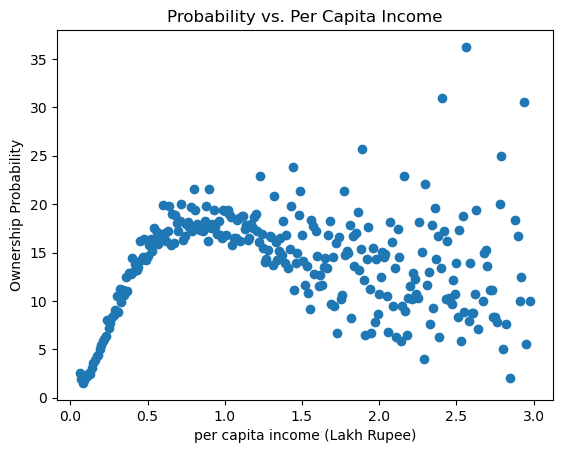

,per_capita_income,income_count,total_four_wheeler_count,ownership_probability
0,0.24,4542,365.969394,8.057450
1,0.18,3988,176.141058,4.416777
2,0.20,3860,210.070344,5.442237
3,0.14,3665,114.172352,3.115207
4,0.16,3583,140.403460,3.918601
...,...,...,...,...
317,2.91,5,0.500000,10.000000
325,2.75,4,0.333333,8.333333
328,2.79,4,1.000000,25.000000
334,2.39,4,0.250000,6.250000


In [104]:
# Data Preprocessing
df_final = pd.read_csv('2014_scooter.csv')
df_final['per_capita_income'] = pd.to_numeric(df_final['per_capita_income'], errors='coerce')

# Bucketing based on income ranges
df_final['per_capita_income'] = df_final['per_capita_income'].apply(lambda x: round(x, -3))

df_income_counts = df_final['per_capita_income'].value_counts().reset_index()
df_income_counts.columns = ['per_capita_income', 'income_count']

df_four_wheeler_count = df_final.groupby('per_capita_income')['vehicles_owned'].sum().reset_index()
df_four_wheeler_count.columns = ['per_capita_income', 'total_four_wheeler_count']

df_merged = pd.merge(df_income_counts, df_four_wheeler_count, on='per_capita_income')
df_merged = df_merged[df_merged['income_count'] > 0]

df_merged['ownership_probability'] = df_merged['total_four_wheeler_count'] / df_merged['income_count']
df_merged['ownership_probability'] = df_merged['ownership_probability'] * 100
df_merged['per_capita_income'] = df_merged['per_capita_income'] / 100000


df_merged = df_merged[(df_merged['per_capita_income'] < 3) & (df_merged['per_capita_income'] > 0.05)]
df_merged = df_merged[(df_merged['ownership_probability'] < 100) & (df_merged['ownership_probability'] > 0)]

# Plotting
plt.plot(df_merged['per_capita_income'], df_merged['ownership_probability'], marker='o', linestyle='')

plt.xlabel('per capita income (Lakh Rupee)')
plt.ylabel('Ownership Probability')
plt.title('Probability vs. Per Capita Income')
plt.show()
df_merged

gammauFnction r2: 0.3777862822490049
[0.37722245 0.78015364 0.86313474]


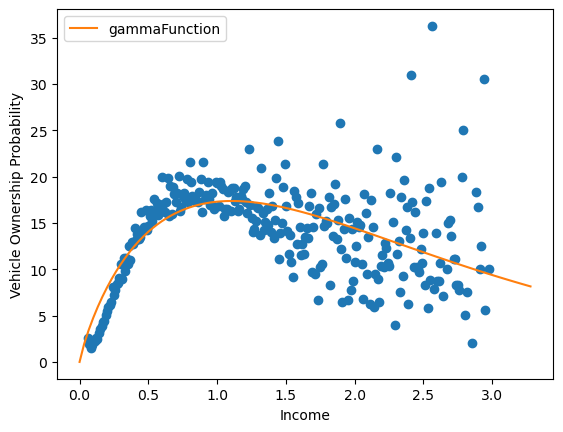

In [105]:
# Define the gamma function
def gammaFunction(x, a, b, c):
    return a * np.exp(-b * x) * x ** c

x = df_merged['per_capita_income']
y = df_merged['ownership_probability'] / 100

plt.plot(x, y * 100, 'o')

pars, pcov = curve_fit(gammaFunction, x, y, maxfev=9000, p0=[-2, 0, max(y)])

plot_x = np.linspace(0, max(x) * 1.1, 100)

plt.plot(plot_x, gammaFunction(plot_x, *pars) * 100, label='gammaFunction')
print('gammauFnction r2:', r2_score(y, gammaFunction(x, *pars)))
print(pars)
plt.xlabel('Income')
plt.ylabel('Vehicle Ownership Probability')
plt.legend()
plt.show()

gammaFunction r2: 0.3777862822490049
[0.37722245 0.78015364 0.86313474]


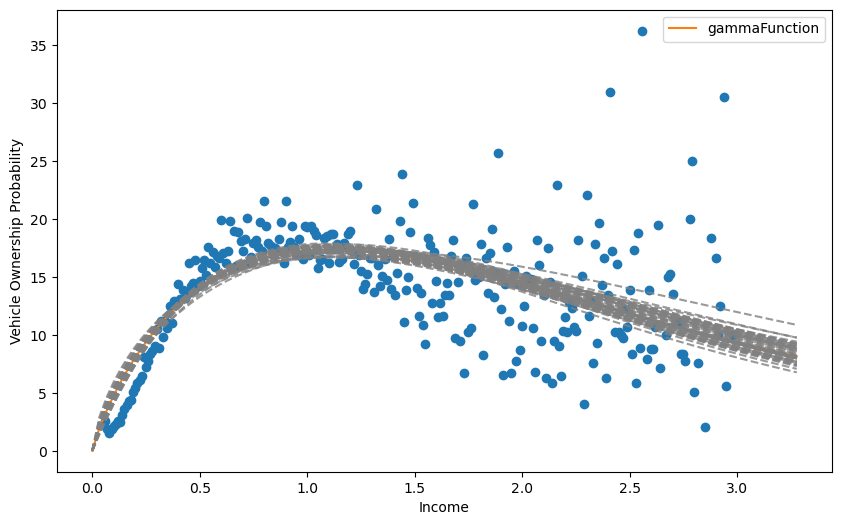

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Define the gamma function
def gammaFunction(x, a, b, c):
    return a * np.exp(-b * x) * x ** c

x = df_merged['per_capita_income']
y = df_merged['ownership_probability'] / 100

plt.figure(figsize=(10, 6))

plt.plot(x, y * 100, 'o')

pars, pcov = curve_fit(gammaFunction, x, y, maxfev=8000, p0=[-2, 0, max(y)])

plot_x = np.linspace(0, max(x) * 1.1, 100)

plt.plot(plot_x, gammaFunction(plot_x, *pars) * 100, label='gammaFunction')
print('gammaFunction r2:', r2_score(y, gammaFunction(x, *pars)))
print(pars)

# Bootstrapping
n_iterations = 50  # Number of bootstrapping iterations

bootstrapped_curves = []
for _ in range(n_iterations):
    # Resample the data points with replacement
    resampled_indices = np.random.choice(range(len(x)), size=len(x), replace=True)
    resampled_x = x.iloc[resampled_indices]
    resampled_y = y.iloc[resampled_indices]

    # Fit the curve to the resampled data
    resampled_pars, _ = curve_fit(gammaFunction, resampled_x, resampled_y, maxfev=8000, p0=[-2, 0, max(resampled_y)])

    # Generate the curve using the resampled parameters
    resampled_curve = gammaFunction(plot_x, *resampled_pars)
    bootstrapped_curves.append(resampled_curve)

# Calculate the mean and confidence intervals
mean_curve = np.mean(bootstrapped_curves, axis=0)
lower_curve = np.percentile(bootstrapped_curves, 2.5, axis=0)
upper_curve = np.percentile(bootstrapped_curves, 97.5, axis=0)

# # Plot the mean curve
# plt.plot(plot_x, mean_curve * 100, color='red', label='Mean Curve')

# Plot the bootstrapped curves
for curve in bootstrapped_curves:
    plt.plot(plot_x, curve * 100, color='gray', linestyle='--', alpha=0.8)
plt.xlabel('Income')
plt.ylabel('Vehicle Ownership Probability')
plt.legend()
plt.show()